# Understanding how the directed FGOC score predicts membership in operons
The scripts are aimed at justifying the use of FGOC or dirFGOC scores. The main point is that the higher the score , higher is the chance that the gene pairs are within operons. <br />
A few reference organisms and their operons are selected. For example E.coli and B.subtilis
Database used: <br />
<ol>
<li>[MicrobesOnline](http://meta.microbesonline.org/operons/) : (downloaded on 27th Sept 2015).<br />
A number of organisms has to be individually downloaded. Organisms chosen - <br />
            (a) eco: Escherichia coli str. K-12 substr. MG1655 <br />
            (b) bsu: Bacillus subtilis subsp. subtilis 168 <br /></li>
<li> OperonDB [ODB3](http://operondb.jp/) : (downloaded on 4th Oct 2015) <br />
All the conserved operons across all species (~ 2,800) is downloaded </li>
</ol>
            

Histogram is plotted for the frequency of dirFGOC score between gene pairs in the organism. The histogram for gene pairs occuring within an operon and those between operon is compared.
A fractional odds ratio is calculate to better illustrate the fact that higher the dirFGOC score is more likely it is to be in an operon. 


In [1]:
import pickle
import os

def loadPkl(fname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklDir,fname)
    db = pickle.load(open(f))
    return db

In [1]:
import pickle
import os
import time

locus_cog_dict = loadPkl('locus_cog.dict.pkl')
cogPair_fgocInfo_dict = loadPkl('cogPair_fgocInfo.dict.pkl')

print "Dictionaries loaded at ",time.ctime()

Dictionaries loaded at  Sat Nov  7 13:56:52 2015


In [160]:
operondbDir = '/home/jaggu/research/downloads/operons_databases/microbesOnline'
sourceDir = '/home/jaggu/research/allGenomePttFiles'

# THIS IS WHERE YOU SHOULD CHANGE THE organism 
org = 'eco' 
orgName = ('Escherichia_coli_K_12_substr__MG1655_uid57779','NC_000913')
#org = 'bsu'
#orgName = ('Bacillus_subtilis_168_uid57675', 'NC_000964')

fname = org+'.'+'operon'
ifile = open(os.path.join(operondbDir,fname))
lines = ifile.readlines()
ifile.close()

# Dictionary
wOp_dict = dict() #Dictioanry of lTagPair:[dirFGOC,fgoc] for within Operon pairs
bwOp_dict = dict() #Dictionary of lTagPair:[dirFGOC,fgoc] for between Operon pairs

# Calculating orientation 
orgDir = os.path.join(sourceDir,orgName[0])
orgPttFile = os.path.join(orgDir,orgName[1]+'.ptt') 
orientationDict = dict()

def getOrientation(orgPttFile):
    #Get orientation right
    ifile = open(orgPttFile,'r')
    lines = ifile.readlines()
    ifile.close()
    orientationDict = dict()
    for line in lines[3:]:
        orientation,lTag = line.split('\t')[1],line.split('\t')[5]
        orientationDict[lTag]=orientation
    return orientationDict
orientationDict = getOrientation(orgPttFile)

def getCog(lTag):
    try:
        cog = locus_cog_dict[lTag]
    except KeyError:
        cog = 'nan'
    if cog == '-': cog = 'nan' #Some wierd bug
    return cog

def getFgocInfo(lTag1,lTag2):
    cogA = getCog(lTag1)
    cogB = getCog(lTag2)
    if cogA is 'nan' or cogB is 'nan':
        return None
    else:
        orientationA = orientationDict[lTag1]
        orientationB = orientationDict[lTag2]
        if orientationA == orientationB == '+':
            cogPair = (cogA,cogB)
        elif orientationA == orientationB == '-':
            cogPair = (cogB,cogA)
        else: 
            cogPair = (cogA,cogB)
        fgocInfo = cogPair_fgocInfo_dict[cogPair]
        #try: fgocInfo = cogPair_fgocInfo_dict[cogPair]
        #except KeyError: fgocInfo = cogPair_fgocInfo_dict[(cogB,cogA)] #Opposite strand
    return fgocInfo

for line in lines[1:]:
    lTag1,lTag2,bOp = [line.split('\t')[i] for i in [2,3,6]]
    fgocInfo = getFgocInfo(lTag1,lTag2)
    if fgocInfo:
        dirFgoc,fgoc = fgocInfo[3],fgocInfo[4]
        if bOp == 'TRUE':
            wOp_dict[(lTag1,lTag2)]=[dirFgoc,fgoc]
        else:
            bwOp_dict[(lTag1,lTag2)]=[dirFgoc,fgoc]

print "Within and Between operon Dictionaries created for Org : %s"%(org)
print "Number of within operon gene pairs (mapped to COG)  : %d"%(len(wOp_dict))
print "Number of between operon gene pairs (mapped to COG) : %d"%(len(bwOp_dict))


Within and Between operon Dictionaries created for Org : eco
Number of within operon gene pairs (mapped to COG)  : 1422
Number of between operon gene pairs (mapped to COG) : 753


Analysing operons for eco organism ...


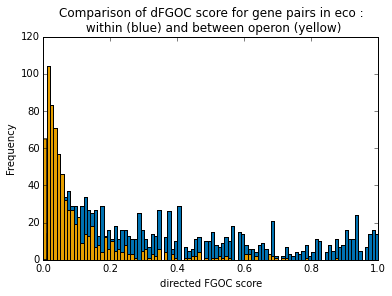

In [165]:
print "Analysing operons for %s organism ..."%(org)
imgDir = '/home/jaggu/research/projectFiles/figures'

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.Figure()
ax = fig.add_subplot(1,1,1)

w_vals = [wOp_dict.values()[i][0] for i in range(0,len(wOp_dict))]
bw_vals = [bwOp_dict.values()[i][0] for i in range(0,len(bwOp_dict))]

n_w,bins_w,patches_w = plt.hist(w_vals,bins=np.arange(0,1.01,0.01),color='#0072b2')
n_bw,bins_bw,patches_bw = plt.hist(bw_vals,bins=np.arange(0,1.01,0.01),color='#e69f00')
plt.xlabel('directed FGOC score')
plt.ylabel('Frequency')
plt.title('Comparison of dFGOC score for gene pairs in %s : \n within (blue) and between operon (yellow)'%(org))
#plt.show()

# Saving figure
fname = org+'_opAndbwOp_genePairs.hist.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)

Analysing operons for eco organism ...


/home/jaggu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


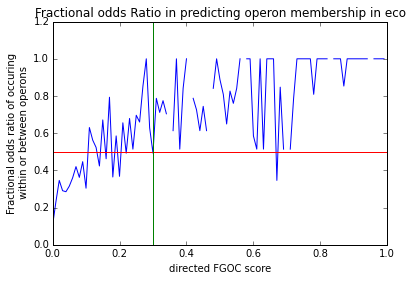

In [167]:
print "Analysing operons for %s organism ..."%(org)

prob_w = n_w/len(wOp_dict)
prob_bw = n_bw/len(bwOp_dict)

yVal = prob_w/(prob_w + prob_bw) #Fraction Odds ratio -> prob(within operon)/(prob(within)+prob(between))

xVal = np.arange(0,1.,0.01)
plt.plot(xVal,yVal,)
plt.axhline(y=0.5,color='r')
plt.axvline(x=0.3,color='g')
plt.ylim([0,1.2])
plt.title('Fractional odds Ratio in predicting operon membership in '+ org)
plt.xlabel('directed FGOC score')
plt.ylabel('Fractional odds ratio of occuring \n within or between operons')
#plt.show()

# Saving figure
fname = org+'_oddsRatio_opAndbwOp.linePlot.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)


# Normalizing the graphs by spanning operonic genes across all species
The motive is to try normalizing this odds ratio plot across all predicted operons. There are many sources for 
predicted operons. But the one downloadable file across all bacteria appears to be from [ODB3](http://operondb.jp/) ; Locus tag is used as an identifier. The statistics of this database reported is that ~ 2800 genomes are used in their prediction. The steps involved are - 
<ol>
<li> Make a huge list of all COG pairs that are classified to be in operons (from the conserved_operon.download.txt: done on 4th October 2015) </li>
<li> For every organism, there is a list of all COG pairs. Two different COG_list are made : (operon COGpair list) and (not Operon COGpair list); </li>
<li> Get FGOC score for each list (CogPair); org : [dirfgoc score list for Operon], [dirfgoc score list for non operon] </li>
<li> For the dirFgoc score list we make a histogram; Also normalize the histogram to the len of the COG list (operon or not operon respectively); The bin size is 0.1 from 0 to 1 </li>
<li> Then average this list across all organisms; The total number of organisms spanned is 2,658 </li></ol>

In [59]:
# Making a gigantic COG pair list that spreads across all species; from odb;
# Load dictionaries
import os

opDBdir = '/home/jaggu/research/downloads/operons_databases/odb3'
pklPath = '/home/jaggu/research/projectFiles/operons/pklFiles'
fname = 'conserved_operon.download.txt'

def getCog(lTag):
    try:
        cog = locus_cog_dict[lTag]
    except KeyError:
        cog = 'nan'
    if cog == '-': cog = 'nan' #Some wierd bug
    return cog

def savePkl(db,pklFname):
    f = os.path.join(pklPath,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

allOp_COGpairs_list = list()

with open(os.path.join(opDBdir,fname)) as f:
    for line in f:
        if not line.startswith('coid'):
            allLTags = line.split('\t')[2]
            lTag_list = allLTags.split(',')
            lTagPairs = zip(lTag_list,lTag_list[1:])
            for lTagPair in lTagPairs:
                lTag1,lTag2 = lTagPair
                cogA,cogB = getCog(lTag1),getCog(lTag2)
                if not('nan' is cogA or 'nan' is cogB):
                    cogPair = (cogA,cogB)
                    if not cogPair in allOp_COGpairs_list: 
                        allOp_COGpairs_list.append(cogPair)

savePkl(allOp_COGpairs_list,'allOperon_COGpairs.list.pkl')
print "All operon COGpairs list Pickled"

All operon COGpairs list Pickled


In [ ]:
# Loading relevant dictionaries
import cPickle as pickle
import os

def loadPkl(fname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklDir,fname)
    db = pickle.load(open(f))
    return db

org_cogPair_dict = loadPkl('org_cogPair.dict.pkl')
allOp_COGpairs_list = loadPkl('allOperon_COGpairs.list.pkl')

In [154]:
# Iterating through all the organisms with its cogPairs and calculating the histogram of operon gene pairs and not 
# operon gene pairs; 
import numpy as np

org_normHist_dict = dict()

def getFgocScore(cogPair):
    fgocInfo = cogPair_fgocInfo_dict[cogPair]
    dirFgoc = fgocInfo[3]
    return dirFgoc

def getHistogramVals(allPairs):
    all_dFgoc_list = list()
    for cogPair in allPairs:
        dirFgoc = np.float(getFgocScore(cogPair))
        all_dFgoc_list.append(dirFgoc)
    valHist_dfgoc,binnings = np.histogram(all_dFgoc_list,bins=np.arange(0,1.01,0.01))
    normHist_dfgoc = np.divide(valHist_dfgoc, len(allPairs),dtype=float)
    return normHist_dfgoc

for org, org_cogPairList in org_cogPair_dict.items():
    # Removing all instances of '-' as the COG pair
    org_cogPairList = [item for item in org_cogPairList if not (item[0] =='-' or item[1] =='-')]
    allOp_dfgoc = list()
    allnotOp_dfgoc = list()
    
    opPairs = list(set(org_cogPairList)&set(allOp_COGpairs_list))
    notOpPairs = list(set(org_cogPairList)-set(allOp_COGpairs_list))
    
    if len(opPairs)> 0: opNormHist_list = getHistogramVals(opPairs) #Plasmids get included and makes it nan
    if len(notOpPairs)>0: notOpNormHist_list = getHistogramVals(notOpPairs)
    org_normHist_dict[org] = (opNormHist_list,notOpNormHist_list)

allOp_hist = list()
allNotOp_hist = list()
for i, (opArray,notOpArray) in enumerate(org_normHist_dict.values()):
    allOp_hist.append(opArray)
    allNotOp_hist.append(notOpArray)

norm_op = np.mean(allOp_hist,axis=0)
norm_notOp = np.mean(allNotOp_hist,axis=0)

print "Normalized histogram values of Operon dirFGOC and not Operon dirFGOC gene pairs calculated for all species"
print "Number of organisms considered : %d "%(len(allOp_hist))

Normalized histogram values of Operon dirFGOC and not Operon dirFGOC gene pairs calculated for all species
Number of organisms considered : 2658 


/home/jaggu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


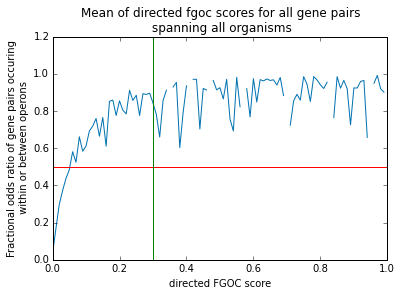

In [168]:
# Plotting the fractional odds ratio of gene pairs within and between operons

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


yVal = norm_op/(norm_op + norm_notOp) #Fraction Odds ratio -> prob(within operon)/(prob(within)+prob(between))
xVal = np.arange(0,1.,0.01)

plt.plot(xVal,yVal,color='#0072b2')
plt.axhline(y=0.5,color='r')
plt.axvline(x=0.3,color='g')
plt.ylim([0,1.2])
plt.title('Mean of directed fgoc scores for all gene pairs \n spanning all organisms')
plt.xlabel('directed FGOC score')
plt.ylabel('Fractional odds ratio of gene pairs occuring \n within or between operons')

#plt.show()

# Saving figure
fname = 'allOrgs_oddsRatio_opAndbwOp.linePlot.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)


***
# Calculating the conservation of genomic distances across gene pairs with differing FGOC scores.
<body>
The hypothesis is that there is no real correlation between genomic distance and how high the ordered gene pair is. Rearrangements are plentiful and occur all the time. It is not necessary that shorter distances correlate to more conserved pair. More conserved pair may also have some riboswitches in its intergenic sequence. 
</body>


In [23]:
import time
# Loading relevant dictionaries
cogPair_bpdist = loadPkl('cogPair_bpdist.dict.pkl')
cogPair_fgocInfo_dict = loadPkl('cogPair_fgocInfo.dict.pkl')
cog_func_dict = loadPkl('cogFunc.dict.pkl')
print "Dictionaries loaded",time.ctime()

Dictionaries loaded Mon Nov 16 14:01:30 2015


In [38]:
# Plotting correlation with dfgoc and mean genetic distance
import numpy as np

dist_dfgoc_list = list()
cutoff = 0.1

def printMeanDistPairs(meanDist,cogA,cogB,count,dfgoc,aNbr,bNbr,cog_func_dict):
    print "Interesting cutoff mean distance COG pairs"
    print meanDist, cogA, cogB, count, dfgoc, aNbr, bNbr
    print cog_func_dict[cogA][1]
    print cog_func_dict[cogB][1]
    print "***"

for cogPair, distList in cogPair_bpdist.items():
    meanDist = np.mean(distList)
    stdevDist = np.std(distList)
    cogA, cogB, count, dfgoc, fgoc, aNbr, bNbr = cogPair_fgocInfo_dict[cogPair]
    if not (cogA.startswith('nan') or cogB.startswith('nan')):
        if float(dfgoc)>cutoff and int(count)>100:
            dist_dfgoc_list.append((cogA,cogB,meanDist,stdevDist,dfgoc,fgoc,count))
            #if meanDist > 300: #Seems to be cutoff used in other papers for operon prediction
                #print MeanDistPairs(meanDist,cogA,cogB,count,dfgoc,aNbr,bNbr,cog_func_dict)
                
print "Number of filtered COG pairs serving this criteria...",len(dist_dfgoc_list)
print "List made",time.ctime() 

Number of filtered COG pairs serving this criteria... 1784
List made Mon Nov 16 14:12:01 2015


Plot done at  Mon Nov 16 14:23:24 2015


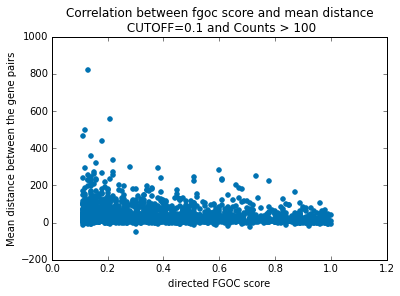

In [46]:
imgDir = '/home/jaggu/research/projectFiles/operons/figures'

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# dist_dfgoc_list : (cogA,cogB,meanDist,stdevDist,dfgoc,fgoc,count)

meansVals = [item[2] for item in dist_dfgoc_list]
stdevVals = [item[3] for item in dist_dfgoc_list]
dfgocVals = map(float,(item[4] for item in dist_dfgoc_list))
fgocVals = map(float,(item[5] for item in dist_dfgoc_list))
counts = map(float,(item[6] for item in dist_dfgoc_list))

xList = dfgocVals
yList = meansVals
#yList = stdevVals
plt.scatter(xList,yList,color='#0072B2')
#sc = plt.scatter(xList,yList,c=counts,cmap='RdYlBu')
#plt.colorbar(sc)
plt.xlabel('directed FGOC score')
plt.ylabel('Mean distance between the gene pairs')
plt.title('Correlation between fgoc score and mean distance \n CUTOFF='+str(cutoff)+' and Counts > 100 ')

# Saving figure
fname = 'dfgoc_meanInterdist_cutoffCounts01.scatter.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)

print "Plot done at ",time.ctime()

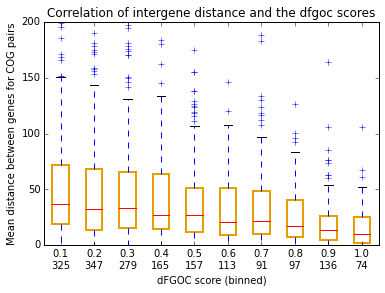

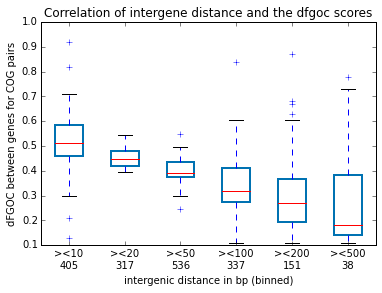

Completed Mon Nov 16 15:35:55 2015


In [84]:
# Replotting this but as bar charts or box plots; Binning the dfgoc or distance scores
import collections

plt.close()

dfgoc_distList_dict = collections.defaultdict(list)
dist_dfgoc_dict = collections.defaultdict(list) 

for (cogA, cogB, meanDist,stdevDist,dfgoc,fgoc,count) in dist_dfgoc_list:
    key_dfgoc = round(dfgoc,1) #0.1, 0.2,...
    dfgoc_distList_dict[key_dfgoc].append(meanDist)
    key_dist = round(meanDist,0)
    dist_dfgoc_dict[key_dist].append(dfgoc)
    
dfgoc_distList_ord = collections.OrderedDict(sorted(dfgoc_distList_dict.items()))
allDist_data = list()
for k,v in dfgoc_distList_ord.items():
    allDist_data.append(v)

# Box plot of the mean intergenic distance for each COG pair    
fig, axes = plt.subplots(nrows=1, ncols=1)
bbplot = axes.boxplot(allDist_data,vert=True,patch_artist=True)   
for box in bbplot['boxes']:
    # change outline color
    box.set( edgecolor='#e69f00', linewidth=2)
    #box.set( facecolor = '#e69f00' )
dfgoc_labels = map(str,np.arange(cutoff,1.1,0.1))
nbr_inBins = map(str,[len(item) for item in allDist_data])
xlabels = [item[0]+'\n'+item[1] for item in zip(dfgoc_labels,nbr_inBins)]

plt.setp(axes, xticks=range(1,len(xlabels)+1,1),xticklabels=xlabels)
plt.xlabel('dFGOC score (binned)')
plt.ylabel('Mean distance between genes for COG pairs')
plt.title('Correlation of intergene distance and the dfgoc scores')
axes.set_ylim([0,200])

# Saving figure
fname = 'bin_dfgoc_meanInterdist_yLimaxis.boxplot.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)
plt.show()
plt.close()

# Understanding the variation of distances 
dist_bins = [10,20,50,100,200,500]
binDist_dfgoc_dict = collections.defaultdict(list)
for dist,dfgocList in dist_dfgoc_dict.items():
    if dist <= 10: 
        binDist_dfgoc_dict[10].append((dist,np.mean(dfgocList),len(dfgocList)))
    elif 10<dist<=20:
        binDist_dfgoc_dict[20].append((dist,np.mean(dfgocList),len(dfgocList)))
    elif 20<dist<=50:
        binDist_dfgoc_dict[50].append((dist,np.mean(dfgocList),len(dfgocList)))
    elif 50<dist<=100:
        binDist_dfgoc_dict[100].append((dist,np.mean(dfgocList),len(dfgocList)))
    elif 100<dist<=200:
        binDist_dfgoc_dict[200].append((dist,np.mean(dfgocList),len(dfgocList)))
    else:
        binDist_dfgoc_dict[300].append((dist,np.mean(dfgocList),len(dfgocList)))

alldfgoc_data = list()
alllen_data = list()
for k,v in sorted(binDist_dfgoc_dict.items()):
    alldfgoc_data.append([item[1] for item in v])
    alllen_data.append([item[2] for item in v])
    
# Box plot of the mean dfgoc score for each intergenic distance bin    
fig, axes = plt.subplots(nrows=1, ncols=1)
bbplot = axes.boxplot(alldfgoc_data,vert=True,patch_artist=True)   
for box in bbplot['boxes']:
    # change outline color
    box.set( edgecolor='#0072b2', linewidth=2)
    # change fill color
    #box.set( facecolor = '#e69f00' )
dist_labels = map(str,dist_bins)
nbrs = [sum(item) for item in alllen_data]

nbr_inBins = map(str,[sum(item) for item in alllen_data])
xlabels = ['><'+item[0]+'\n'+item[1] for item in zip(dist_labels,nbr_inBins)]

plt.setp(axes, xticks=range(1,7,1),xticklabels=xlabels)
plt.xlabel('intergenic distance in bp (binned)')
plt.ylabel('dFGOC between genes for COG pairs')
plt.title('Correlation of intergene distance and the dfgoc scores')

# Saving figure
fname = 'bin_meanInterdist_dfgoc.boxplot.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)
plt.show()

print "Completed",time.ctime()

In [80]:
# Getting examples of deviant cog pairs

for (cogA, cogB, meanDist,stdevDist,dfgoc,fgoc,count) in dist_dfgoc_list:
    if float(dfgoc)>0.5 and meanDist>200:
        print "\t".join(map(str,(cogA,cogB,meanDist,dfgoc,count,cog_func_dict[cogA][1],cog_func_dict[cogB][1])))
    

COG0222	COG0085	284.056537102	0.6	849	Ribosomal protein L7/L12	DNA-directed RNA polymerase, beta subunit/140 kD subunit
COG4796	COG0703	236.128378378	0.61	296	Type II secretory pathway, component HofQ	Shikimate kinase
COG0081	COG0244	222.116117851	0.78	1154	Ribosomal protein L1	Ribosomal protein L10
COG3343	COG0504	250.627218935	0.73	169	DNA-directed RNA polymerase, delta subunit	CTP synthase (UTP-ammonia lyase)
COG2088	COG1207	244.794117647	0.51	136	DNA-binding protein SpoVG, cell septation regulator	Bifunctional protein GlmU, N-acetylglucosamine-1-phosphate-uridyltransferase/glucosamine-1-phosphate-acetyltransferase
COG0184	COG1185	204.818367347	0.66	980	Ribosomal protein S15P/S13E	Polyribonucleotide nucleotidyltransferase (polynucleotide phosphorylase)
COG0593	COG0592	223.372003835	0.51	1043	Chromosomal replication initiation ATPase DnaA	DNA polymerase III sliding clamp (beta) subunit, PCNA homolog
COG5512	COG0187	227.358974359	0.61	117	Predicted  nucleic acid-binding protein, conta

### Summary
<body> It appears that there is a (maybe weak) correlation between the dfgoc score and the intergenetic distance between the genes making up the COG pairs. After applying the filter (dfgoc > 0.1 and the counts >100, I got about 1784 COG pairs. Although the simple scatter plot was very messy and difficult to intepret, I redid this by binning and applying a box plot. The higher the dfgoc score, the smaller the genetic distance appears to be. There is also some relationship between the number of pairs making up the dfgoc bin and the mean genetic distance. Lower dfgoc score bins, have more members. There may be some effect on the mean distances, but atleast a box plot representation may show some unbiased results. </body>
***

## Calculating the GC content of intergenic COG pairs
<body>
I am wanting to test out the hypothesis if the COG pairs with high scores imply they are difficult to break. So probably if they have higher GC content (as percentage), they may be more biased to having a high dfgoc score
</body>


In [21]:
import time

cogPair_GCcontent_dict = loadPkl('cogPair_GCcontent.dict.pkl')
cogPair_fgocInfo_dict = loadPkl('cogPair_fgocInfo.dict.pkl')
cog_func_dict = loadPkl('cogFunc.dict.pkl')

print "Dictionaries loaded at ",time.ctime()

Dictionaries loaded at  Mon Nov 16 13:56:48 2015


In [42]:
import numpy as np

gc_dfgoc_list = list()
cutoff = 0.1
count

for cogPair,GCList in cogPair_GCcontent_dict.items():
    cogA, cogB, count, dfgoc, fgoc, aNbr, bNbr = cogPair_fgocInfo_dict[cogPair]
    allGeneA_GC, allGeneB_GC, allIntergene_GC = zip(*GCList)
    meanGeneA_GC, meanGeneB_GC, meanIntergene_GC = map(np.mean,[allGeneA_GC,allGeneB_GC,allIntergene_GC])
    if not (cogA.startswith('nan') or cogB.startswith('nan')):
        if float(dfgoc)>cutoff and int(count)>100:
            gc_dfgoc_list.append((cogA,cogB,meanGeneA_GC,meanGeneB_GC,meanIntergene_GC,dfgoc,fgoc,count))

print "List created of length : ",len(gc_dfgoc_list),time.ctime()

List created of length :  1784 Mon Nov 16 14:21:33 2015


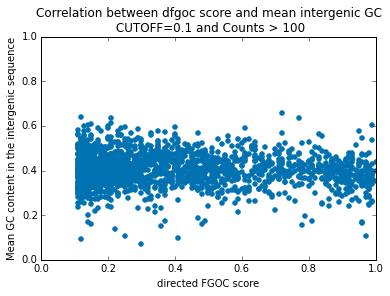

In [57]:
imgDir = '/home/jaggu/research/projectFiles/operons/figures'

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

meanGeneA_GC_vals = [item[2] for item in gc_dfgoc_list]
meanGeneB_GC_vals = [item[3] for item in gc_dfgoc_list]
meanIntergene_GC_vals = [item[4] for item in gc_dfgoc_list]
dfgoc_vals = map(np.float,[item[5] for item in gc_dfgoc_list])

xList = dfgoc_vals
yList = meanIntergene_GC_vals

plt.scatter(xList,yList,color='#0072B2')
plt.xlabel('directed FGOC score')
plt.ylabel('Mean GC content in the intergenic sequence')
plt.title('Correlation between dfgoc score and mean intergenic GC \n CUTOFF='+str(cutoff)+' and Counts > 100 ')
plt.xlim([0,1])
plt.ylim([0,1])

# Saving figure
fname = 'meanGC_dfgoc.scatter.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)
plt.show()


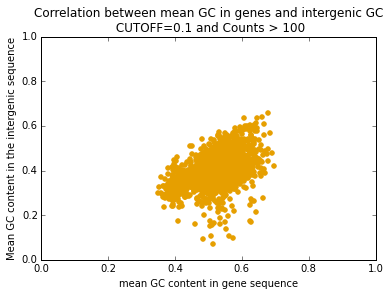

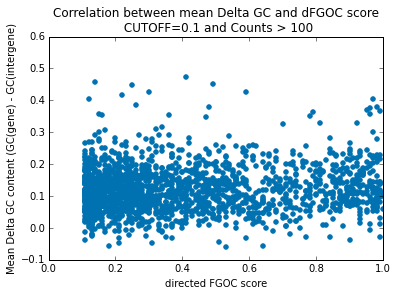

In [62]:
imgDir = '/home/jaggu/research/projectFiles/operons/figures'

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

xList = meanGeneA_GC_vals
yList = meanIntergene_GC_vals

plt.scatter(xList,yList,color='#E69F00')
plt.xlabel('mean GC content in gene sequence')
plt.ylabel('Mean GC content in the intergenic sequence')
plt.title('Correlation between mean GC in genes and intergenic GC \n CUTOFF='+str(cutoff)+' and Counts > 100 ')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

allGC = zip(meanGeneA_GC_vals,meanGeneB_GC_vals,meanIntergene_GC_vals)
delta_GC_vals = [((item[0]+item[1])/2)-item[2] for item in allGC]

xList = dfgoc_vals
yList = delta_GC_vals

plt.xlabel('directed FGOC score')
plt.ylabel('Mean Delta GC content (GC(gene) - GC(intergene) ')
plt.title('Correlation between mean Delta GC and dFGOC score \n CUTOFF='+str(cutoff)+' and Counts > 100 ')

plt.scatter(xList,yList,color='#0072B2')
plt.xlim([0,1])
#plt.ylim([0,0.7])
plt.show()